In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, cohen_kappa_score
)


In [ ]:
TRAIN_DIR = "/content/drive/MyDrive/diseases/train"
TEST_DIR  = "/content/drive/MyDrive/diseases/test"

In [ ]:
from torchvision import datasets
from collections import Counter
import pandas as pd

TRAIN_DIR = "/content/drive/MyDrive/diseases/train"

train_dataset = datasets.ImageFolder(TRAIN_DIR)

train_counts = Counter(train_dataset.targets)
train_classes = train_dataset.classes

df_train_balance = pd.DataFrame({
    "Class": train_classes,
    "Train Images": [train_counts[i] for i in range(len(train_classes))]
})

print("Total TRAIN images:", len(train_dataset))
df_train_balance


Total TRAIN images: 13280


,Class,Train Images
0,bacterial_leaf_blight,1332
1,brown_spot,1349
2,healthy,1385
3,leaf_blast,1368
4,leaf_scald,1385
5,narrow_brown_spot,1371
6,neck_blast,954
7,rice_hispa,1395
8,sheath_blight,1385
9,tungro,1356


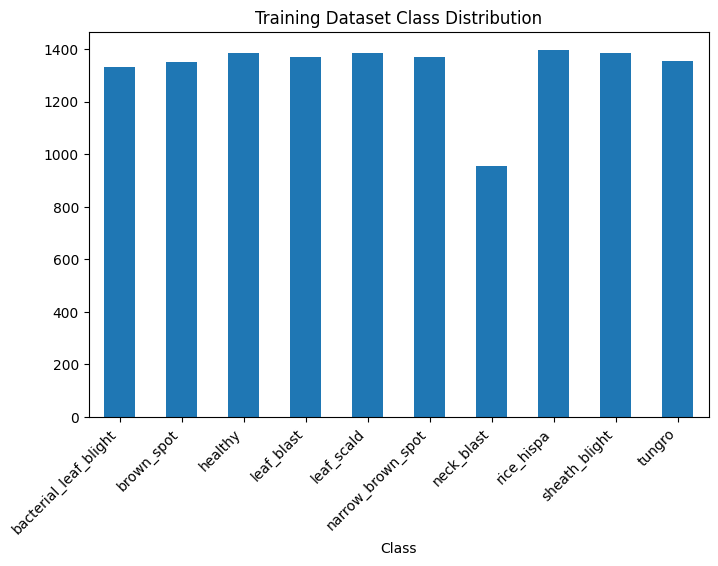

In [ ]:
import matplotlib.pyplot as plt

df_train_balance.plot(
    kind="bar",
    x="Class",
    y="Train Images",
    legend=False,
    figsize=(8,5)
)
plt.title("Training Dataset Class Distribution")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
TEST_DIR = "/content/drive/MyDrive/diseases/test"

test_dataset = datasets.ImageFolder(TEST_DIR)

test_counts = Counter(test_dataset.targets)
test_classes = test_dataset.classes

df_test_balance = pd.DataFrame({
    "Class": test_classes,
    "Test Images": [test_counts[i] for i in range(len(test_classes))]
})

print("Total TEST images:", len(test_dataset))
df_test_balance


Total TEST images: 1929


,Class,Test Images
0,bacterial_leaf_blight,222
1,brown_spot,195
2,healthy,207
3,leaf_blast,165
4,leaf_scald,180
5,narrow_brown_spot,259
6,neck_blast,180
7,rice_hispa,168
8,sheath_blight,195
9,tungro,158


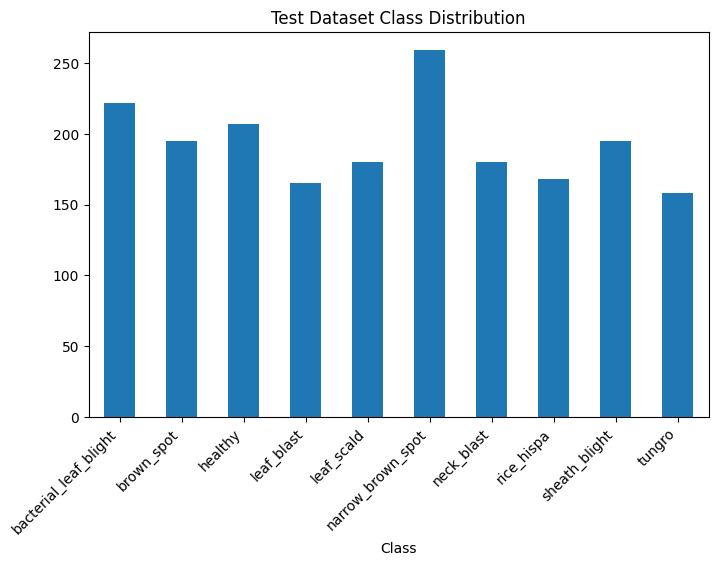

In [ ]:
df_test_balance.plot(
    kind="bar",
    x="Class",
    y="Test Images",
    legend=False,
    figsize=(8,5)
)
plt.title("Test Dataset Class Distribution")
plt.xticks(rotation=45, ha="right")
plt.show()


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% validation
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

Found 10627 images belonging to 10 classes.
Found 2653 images belonging to 10 classes.


In [ ]:
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

Found 1929 images belonging to 10 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


In [ ]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,994 (27.35 MB)

 Trainable params: 132,490 (517.54 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

CHECKPOINT_DIR = "/content/drive/MyDrive/checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint_cb = ModelCheckpoint(
    filepath=f"{CHECKPOINT_DIR}/epoch_{{epoch:02d}}.keras",
    save_freq='epoch',
    save_best_only=False
)


In [ ]:
EPOCHS = 25

model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb]
)



Epoch 1/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 4598s 14s/step - accuracy: 0.7365 - loss: 0.7990 - val_accuracy: 0.8600 - val_loss: 0.4203
Epoch 2/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.8423 - loss: 0.4597 - val_accuracy: 0.9088 - val_loss: 0.2885
Epoch 3/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 351s 1s/step - accuracy: 0.8740 - loss: 0.3741 - val_accuracy: 0.9171 - val_loss: 0.2504
Epoch 4/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.8881 - loss: 0.3140 - val_accuracy: 0.9228 - val_loss: 0.2319
Epoch 5/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 347s 1s/step - accuracy: 0.8981 - loss: 0.2989 - val_accuracy: 0.8533 - val_loss: 0.4405
Epoch 6/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 343s 1s/step - accuracy: 0.9073 - loss: 0.2678 - val_accuracy: 0.9300 - val_loss: 0.1952
Epoch 7/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - accuracy: 0.9089 - loss: 0.2502 - val_accuracy: 0.9362 - val_loss: 0.1791
Epoch 8/25
333/333 ━━━━━━━━━━━━━━━━━━━━ 352s 1s/step - accuracy: 0.9160 - loss: 0.2341 - val_ac

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
train_gen = ...
test_gen = ...


In [ ]:
start_epoch = int(latest.split("_")[-1].split(".")[0])
print("Resuming from epoch:", start_epoch)


In [ ]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print("\nTest Loss     :", test_loss)
print("Test Accuracy :", test_accuracy)

61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 651ms/step - accuracy: 0.9592 - loss: 0.1158

Test Loss     : 0.0844159871339798
Test Accuracy : 0.9704509973526001


In [ ]:
accuracy_percent = test_accuracy * 100
print(f"Test Accuracy: {accuracy_percent:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 97.05%
Test Loss: 0.0844


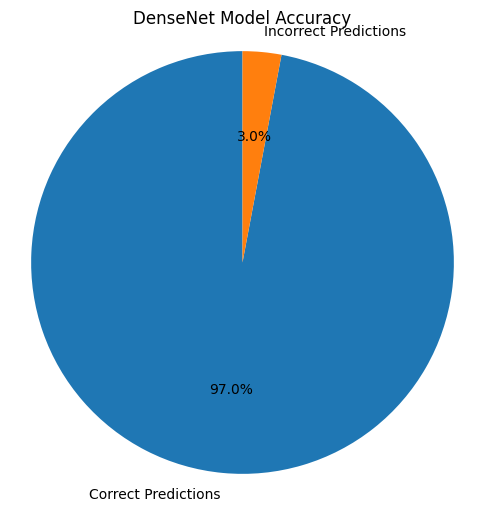

In [ ]:
import matplotlib.pyplot as plt

# Accuracy calculation
accuracy = test_accuracy
error = 1 - accuracy

labels = ['Correct Predictions', 'Incorrect Predictions']
sizes = [accuracy, error]

plt.figure(figsize=(6,6))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title('DenseNet Model Accuracy')
plt.axis('equal')  # Circle shape
plt.show()


61/61 ━━━━━━━━━━━━━━━━━━━━ 71s 862ms/step


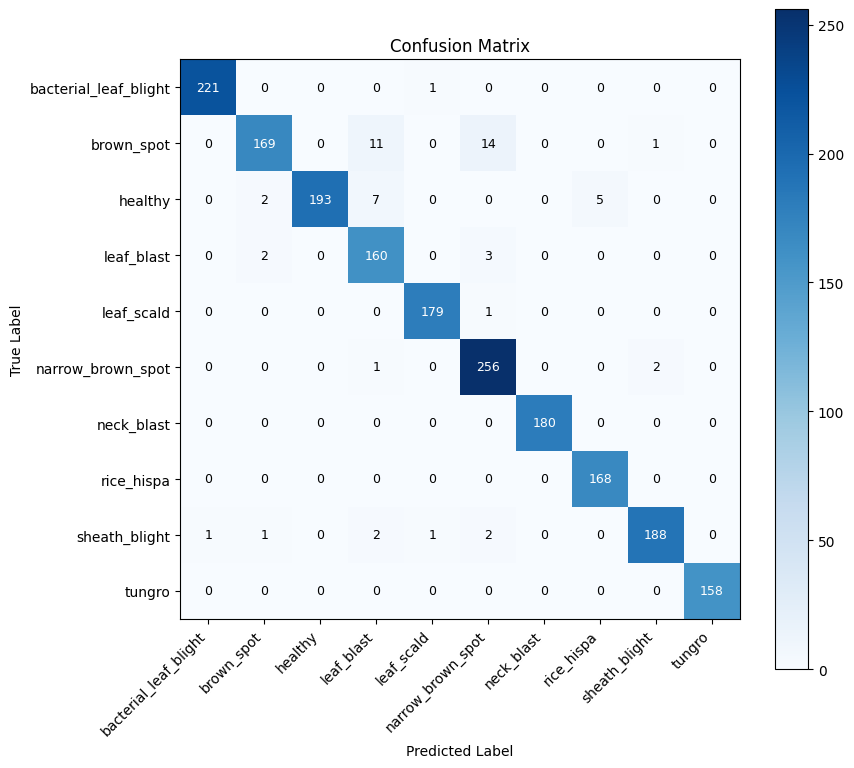

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# True & Predicted labels
y_true = test_gen.classes
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(9,8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")


thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            fontsize=9,
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import math
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, mean_squared_error, cohen_kappa_score, classification_report
)
import matplotlib.pyplot as plt

steps = math.ceil(test_gen.samples / test_gen.batch_size)
y_pred_prob = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes

print("y_true:", len(y_true))
print("y_pred:", len(y_pred))

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall    = recall_score(y_true, y_pred, average="weighted")
f1        = f1_score(y_true, y_pred, average="weighted")
mse       = mean_squared_error(y_true, y_pred)
kappa     = cohen_kappa_score(y_true, y_pred)

print("\n=== MODEL PERFORMANCE METRICS ===")
print("Accuracy   :", accuracy)
print("Precision  :", precision)
print("Recall     :", recall)
print("F1-Score   :", f1)
print("MSE        :", mse)
print("Kappa      :", kappa)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


61/61 ━━━━━━━━━━━━━━━━━━━━ 45s 726ms/step
y_true: 1929
y_pred: 1929

=== MODEL PERFORMANCE METRICS ===
Accuracy   : 0.9704510108864697
Precision  : 0.9717872060873071
Recall     : 0.9704510108864697
F1-Score   : 0.9703620846830587
MSE        : 0.3665111456713323
Kappa      : 0.967082640525897

Classification Report:

                       precision    recall  f1-score   support

bacterial_leaf_blight       1.00      1.00      1.00       222
           brown_spot       0.97      0.87      0.92       195
              healthy       1.00      0.93      0.96       207
           leaf_blast       0.88      0.97      0.92       165
           leaf_scald       0.99      0.99      0.99       180
    narrow_brown_spot       0.93      0.99      0.96       259
           neck_blast       1.00      1.00      1.00       180
           rice_hispa       0.97      1.00      0.99       168
        sheath_blight       0.98      0.96      0.97       195
               tungro       1.00      1.00      1.

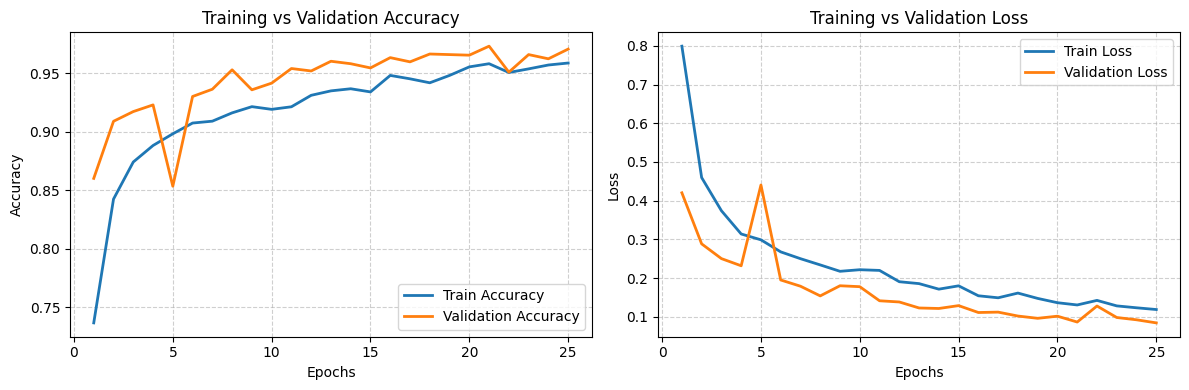

In [1]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 26))

# ====== Accuracy (from your results) ======
train_acc = [
    0.7365, 0.8423, 0.8740, 0.8881, 0.8981,
    0.9073, 0.9089, 0.9160, 0.9213, 0.9190,
    0.9212, 0.9310, 0.9348, 0.9366, 0.9339,
    0.9480, 0.9451, 0.9417, 0.9480, 0.9553,
    0.9580, 0.9505, 0.9536, 0.9569, 0.9586
]

val_acc = [
    0.8600, 0.9088, 0.9171, 0.9228, 0.8533,
    0.9300, 0.9362, 0.9528, 0.9357, 0.9414,
    0.9539, 0.9518, 0.9601, 0.9580, 0.9544,
    0.9632, 0.9596, 0.9663, 0.9658, 0.9653,
    0.9730, 0.9508, 0.9658, 0.9622, 0.9705
]

# ====== Loss (from your results) ======
train_loss = [
    0.7990, 0.4597, 0.3741, 0.3140, 0.2989,
    0.2678, 0.2502, 0.2341, 0.2176, 0.2217,
    0.2199, 0.1907, 0.1858, 0.1715, 0.1801,
    0.1544, 0.1492, 0.1614, 0.1476, 0.1365,
    0.1307, 0.1425, 0.1283, 0.1234, 0.1189
]

val_loss = [
    0.4203, 0.2885, 0.2504, 0.2319, 0.4405,
    0.1952, 0.1791, 0.1541, 0.1803, 0.1779,
    0.1415, 0.1384, 0.1229, 0.1216, 0.1290,
    0.1112, 0.1122, 0.1021, 0.0962, 0.1017,
    0.0866, 0.1280, 0.0983, 0.0924, 0.0844
]

# ====== Plot ======
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy plot
axes[0].plot(epochs, train_acc, label='Train Accuracy', linewidth=2)
axes[0].plot(epochs, val_acc, label='Validation Accuracy', linewidth=2)
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# Loss plot
axes[1].plot(epochs, train_loss, label='Train Loss', linewidth=2)
axes[1].plot(epochs, val_loss, label='Validation Loss', linewidth=2)
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig("training_validation_curve_paper.png", dpi=300)
plt.show()


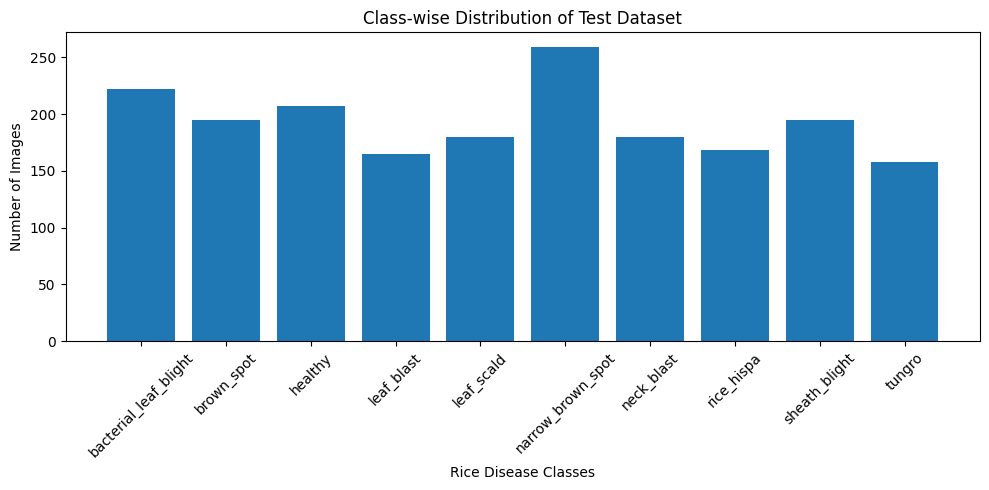

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

class_counts = pd.Series(test_gen.classes).value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(class_names, class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Rice Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Distribution of Test Dataset")
plt.tight_layout()
plt.show()

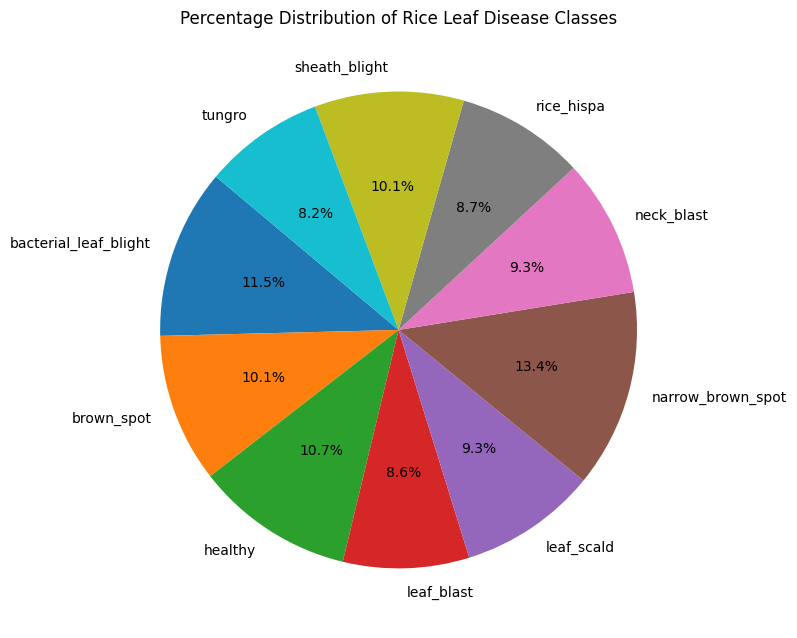

In [ ]:

plt.figure(figsize=(8,8))
plt.pie(
    class_counts.values,
    labels=class_names,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Percentage Distribution of Rice Leaf Disease Classes")
plt.tight_layout()
plt.show()

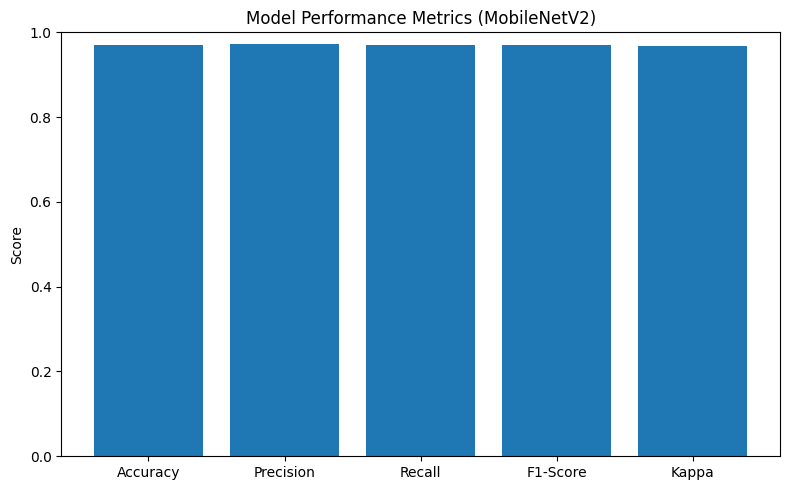

In [ ]:

metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score", "Kappa"]
metrics_values = [accuracy, precision, recall, f1, kappa]

plt.figure(figsize=(8,5))
plt.bar(metrics_names, metrics_values)
plt.ylim(0,1)
plt.title("Model Performance Metrics (MobileNetV2)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

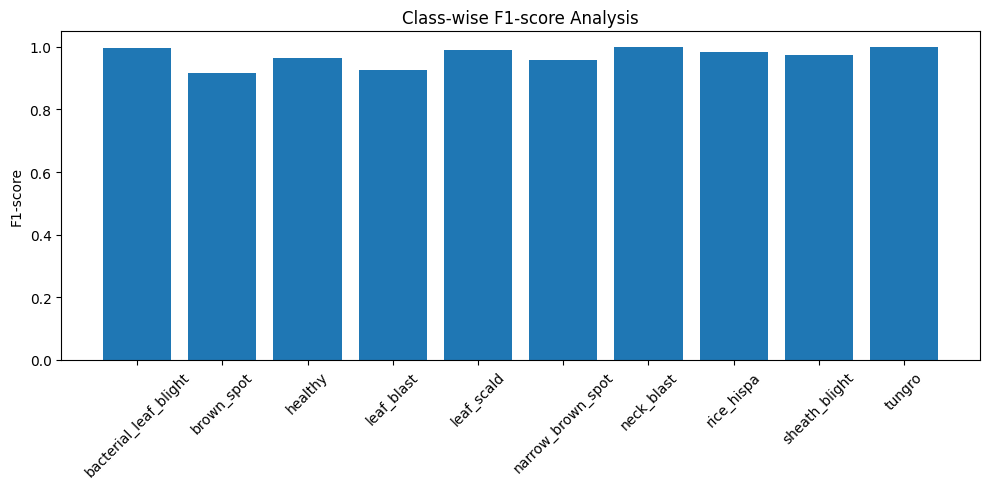

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)

f1_scores = [report[c]["f1-score"] for c in class_names]

plt.figure(figsize=(10,5))
plt.bar(class_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel("F1-score")
plt.title("Class-wise F1-score Analysis")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

 Predicted Class: class_6

Class Probabilities:
class_0: 0.00%
class_1: 0.00%
class_2: 0.00%
class_3: 0.00%
class_4: 0.00%
class_5: 0.00%
class_6: 100.00%
class_7: 0.00%
class_8: 0.00%
class_9: 0.00%

Using last convolutional layer for Grad-CAM: conv5_block16_2_conv


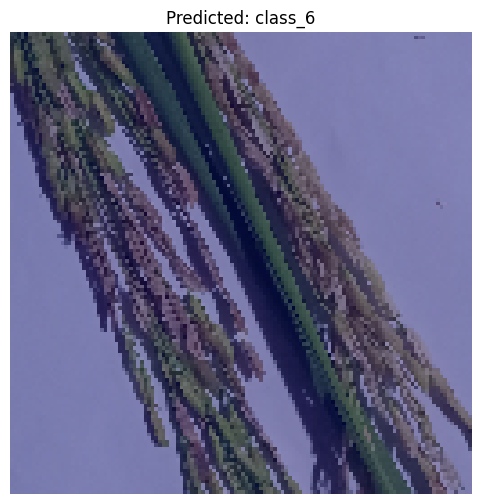

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

class_names = [
    'bacterial_leaf_blight',
    'brown_spot',
    'leaf_smut',
    'neck_blast',
    'healthy',
    'tungro',
    'other_disease',
    'another_class'
]

img_path = "/content/drive/MyDrive/diseases/test/neck_blast/IMG20201109210607_00.jpg"
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array.astype('float32') / 255.0

preds = model.predict(img_array)
class_index = int(np.argmax(preds[0]))
num_classes = preds.shape[1]

if len(class_names) != num_classes:
    class_names = [f"class_{i}" for i in range(num_classes)]

predicted_class_name = class_names[class_index]
print(f"\n Predicted Class: {predicted_class_name}\n")

print("Class Probabilities:")
for i, name in enumerate(class_names):
    print(f"{name}: {preds[0][i]*100:.2f}%")

for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
print(f"\nUsing last convolutional layer for Grad-CAM: {last_conv_layer_name}")

def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8
    return heatmap

heatmap = get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name)

img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (128,128))

heatmap_resized = cv2.resize(heatmap, (128,128))
heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_colored = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title(f"Predicted: {predicted_class_name}")
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/rice_disease_densenet121.h5")